# Implementation of a VAE in pytorch for MNIST generation


## Definition of the VAE class

In [7]:
import numpy as np
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_embedding, n_conditional=0, use_cuda=False):
        super(VAE, self).__init__()
        
        self.use_cuda = use_cuda
        
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_embedding = n_embedding
        self.n_conditional = n_conditional
        
        relu = nn.ReLU()
        sigmoid = nn.Sigmoid()
        
        # Inference network weights
        layers = []
        for i in range(1, len(self.n_hidden)):
            layers.append(nn.Linear(self.n_hidden[i - 1], self.n_hidden[i]))
            layers.append(relu)
        self.inference_layers = nn.Sequential(nn.Linear(self.n_inputs + self.n_conditional,
                                                        self.n_hidden[0]),
                                              relu, *layers)
        
        # Embedding networks weights
        self.mu_layer = nn.Linear(self.n_hidden[-1],
                                  self.n_embedding)
        self.logvar_layer = nn.Linear(self.n_hidden[-1],
                                      self.n_embedding)
        
        # Generative network weights
        layers = []
        for i in range(len(n_hidden) - 1, 0, -1):
            layers.append(nn.Linear(self.n_hidden[i],
                                    self.n_hidden[i - 1]))
            layers.append(relu)
        self.generative_layers = nn.Sequential(nn.Linear(self.n_embedding + self.n_conditional,
                                                         self.n_hidden[-1]),
                                               relu,
                                               *layers,
                                               nn.Linear(self.n_hidden[0],
                                                         self.n_inputs),
                                               sigmoid)
        
        if use_cuda:
            self.inference_layers = self.inference_layers.cuda()
            self.mu_layer = self.mu_layer.cuda()
            self.logvar_layer = self.logvar_layer.cuda()
            self.generative_layers = self.generative_layers.cuda()
    
    def inference_network(self, x, c=None):
        if c is not None:
            x = torch.cat([x, c], 1)
            
        h = self.inference_layers(x)
        return self.mu_layer(h), self.logvar_layer(h)

    def sample_embedding(self, mu, logvar):
        batch_size = mu.size(0)
        eps = torch.randn(batch_size, self.n_embedding)
        if self.use_cuda:
            eps = eps.cuda()
        return mu + torch.exp(logvar / 2) * eps

    def generative_network(self, z, c=None):
        if c is not None:
            z = torch.cat([z, c], 1)
        return self.generative_layers(z)

    def forward(self, x, c=None):
        z_mu, z_logvar = self.inference_network(x, c)
        z = self.sample_embedding(z_mu, z_logvar)
        y = self.generative_network(z, c)
        
        return y, z_mu, z_logvar
    
    def generate(self, c=None):
        self.eval()
        batch_size = c.size(0)
        z = torch.randn(batch_size, self.n_embedding)
        if self.use_cuda:
            z = z.cuda()
        sample = self.generative_network(z, c).detach().cpu().data.numpy()
        
        return sample, z
        
recon_loss = nn.BCELoss()

def vae_loss(inputs, outputs, batch_size):
    recon_data = outputs[0]
    mu = outputs[1]
    logvar= outputs[2]
    
    marginal_liklihood = recon_loss(recon_data, inputs)
    
    KLLoss = torch.mean(0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1. - logvar, 1))
    return marginal_liklihood + KLLoss



## Testing the model's modules

In [2]:
# Testing
model = VAE(28 * 28, [128], 100, use_cuda=False)
for m in model.modules():
    print(m)


VAE(
  (inference_layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
  )
  (mu_layer): Linear(in_features=128, out_features=100, bias=True)
  (logvar_layer): Linear(in_features=128, out_features=100, bias=True)
  (generative_layers): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
)
Linear(in_features=784, out_features=128, bias=True)
ReLU()
Linear(in_features=128, out_features=100, bias=True)
Linear(in_features=128, out_features=100, bias=True)
Sequential(
  (0): Linear(in_features=100, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=784, bias=True)
  (3): Sigmoid()
)
Linear(in_features=100, out_features=128, bias=True)
Linear(in_features=128, out_features=784, bias=True)
Sigmoid()


## Training framework

In [3]:
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.transforms.functional import to_tensor

class History:

    def __init__(self):
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'lr': []
        }

    def save(self, train_loss, val_loss, lr):
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['lr'].append(lr)

    def display_loss(self):
        epoch = len(self.history['train_loss'])
        epochs = [x for x in range(1, epoch + 1)]
        plt.title('Training loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot(epochs, self.history['train_loss'], label='Train')
        plt.plot(epochs, self.history['val_loss'], label='Validation')
        plt.legend()
        plt.show()
    
    def display_lr(self):
        epoch = len(self.history['train_loss'])
        epochs = [x for x in range(1, epoch + 1)]
        plt.title('Learning rate')
        plt.xlabel('Epochs')
        plt.ylabel('Lr')
        plt.plot(epochs, self.history['lr'], label='Lr')
        plt.show()
    
    def display(self):
        epoch = len(self.history['train_loss'])
        epochs = [x for x in range(1, epoch + 1)]

        fig, axes = plt.subplots(2, 1)
        plt.tight_layout()

        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].plot(epochs, self.history['train_loss'], label='Train')
        axes[0].plot(epochs, self.history['val_loss'], label='Validation')
        
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Lr')
        axes[1].plot(epochs, self.history['lr'], label='Lr')

        plt.show()

def _apply(obj, func):
    if isinstance(obj, (list, tuple)):
        return type(obj)(_apply(el, func) for el in obj)
    if isinstance(obj, dict):
        return {k:_apply(el, func) for k, el in obj.items()}
    return func(obj)


def torch_to_numpy(obj, copy=False):
    if copy:
        func = lambda t: t.cpu().detach().numpy().copy()
    else:
        func = lambda t: t.cpu().detach().numpy()
    return torch_apply(obj, func)


def numpy_to_torch(obj):
    fn = lambda a: torch.from_numpy(a) if isinstance(a, np.ndarray) else a
    return _apply(obj, fn)


def validate(model, data_loader, conditional=0, use_cuda=False):
    model.train(False)
    loss_value = []
    model.eval()

    for batch in data_loader:
        
        inputs, c = batch
        
        bs = inputs.size(0)
        
        if conditional > 0:
            c.resize_(bs, 1)
            labels = torch.zeros(bs, 10)
            labels.scatter_(1, c, 1)
        else:
            labels = None
            
        if use_cuda:
            inputs = inputs.cuda()
            if conditional > 0: labels = labels.cuda()

        # Forward
        outputs = model(inputs, labels)

        # Loss
        loss = vae_loss(inputs, outputs, bs)
        loss_value.append(loss.data)

    model.train(True)
    return sum(loss_value) / len(loss_value)


def fit_vae(model, train_dataset, val_dataset, optimizer=None,
            batch_size=32, epochs=10, verbose=True,
            conditional=0, use_cuda=False):
    
    if optimizer is None:
        params = (p for p in model.parameters() if p.requires_grad)
        optimizer = torch.optim.SGD(params, lr = 1e-2)
    
    train_loader = DataLoader(train_dataset, batch_size)
    val_loader = DataLoader(val_dataset, batch_size)
    
    model.train(True)
    start = time.time()
    for i in range(epochs):
        
        for batch in train_loader:
            optimizer.zero_grad()

            inputs, c = batch
            bs = inputs.size(0)
            
            if conditional > 0:
                c.resize_(bs, 1)
                labels = torch.zeros(bs, 10)
                labels.scatter_(1, c, 1)
            else:
                labels = None
            
            
            if use_cuda:
                inputs = inputs.cuda()
                if conditional > 0: labels = labels.cuda()

            # Forward
            outputs = model(inputs, labels)

            # Loss
            loss = vae_loss(inputs, outputs, bs)

            # Backward
            loss.backward()

            # Update
            solver.step()

            optimizer.step()
        
        train_loss = validate(model, train_loader, conditional, use_cuda)
        val_loss = validate(model, val_loader, conditional, use_cuda)
        
        if verbose:
            end = time.time()
            print(f"Epoch {i} - Train loss: {train_loss} - Val loss: {val_loss} - Training time: {end - start}")
            start = time.time()
    
    return None


## Loading MNIST

In [4]:
#from tensorflow.examples.tutorials.mnist import input_data

#mnist = input_data.read_data_sets('mnist', one_hot=True)

from torchvision.datasets import MNIST
from torch.utils.data import Subset
from random import shuffle, sample

def load_data(num_train=-1, num_val=1, numbers=-1):
    dataset = MNIST("testdata/mnist", train=True, download=True)
    if num_train > len(dataset):
        num_train = len(dataset)
    
    dataset.transform = Compose([ToTensor(), Lambda(lambda x: x.resize(28 * 28))])
    
    idx = sample(range(len(dataset)), num_train)
    train_dataset = Subset(dataset, idx)
    
    testset = MNIST("testdata/mnist", train=False, download=True)
    if num_val > len(testset):
        num_val = len(testset)
    
    testset.transform = Compose([ToTensor(), Lambda(lambda x: x.resize(28 * 28))])
    
    idx = sample(range(len(testset)), num_val)
    val_dataset = Subset(testset, idx)

    return train_dataset, val_dataset
    

def display_sample(imag, ax):
    ax.imshow(imag, cmap="Greys")
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.set_aspect('equal')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

## Training a VAE on MNIST

In [8]:
use_cuda = True
conditional = 10

model = VAE(28 * 28, [512, 256, 128], 100, conditional, use_cuda)
solver = torch.optim.Adam(model.parameters(), lr=1e-3)


train_dataset, val_dataset = load_data(num_train=6000, num_val=10000, numbers=-1)

print(f"Training dataset size: {len(train_dataset)} - Validation dataset size: {len(val_dataset)}")

fit_vae(model, train_dataset, val_dataset, optimizer=solver,
        batch_size=64, epochs=20, verbose=True,
        use_cuda=use_cuda, conditional=conditional)


Training dataset size: 6000 - Validation dataset size: 10000


/home/charles_murphy/anaconda3/lib/python3.6/site-packages/torch/tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 0 - Train loss: 0.2621695399284363 - Val loss: 0.26210126280784607 - Training time: 4.390476703643799
Epoch 1 - Train loss: 0.2555694878101349 - Val loss: 0.25513777136802673 - Training time: 4.2925331592559814
Epoch 2 - Train loss: 0.23476701974868774 - Val loss: 0.2335927039384842 - Training time: 4.369873523712158
Epoch 3 - Train loss: 0.22711828351020813 - Val loss: 0.22624433040618896 - Training time: 4.347601890563965
Epoch 4 - Train loss: 0.224288672208786 - Val loss: 0.2232625037431717 - Training time: 4.330503940582275
Epoch 5 - Train loss: 0.22306577861309052 - Val loss: 0.22222726047039032 - Training time: 4.3268773555755615
Epoch 6 - Train loss: 0.2230285406112671 - Val loss: 0.222123384475708 - Training time: 4.319986820220947
Epoch 7 - Train loss: 0.22260327637195587 - Val loss: 0.22179238498210907 - Training time: 4.289435863494873
Epoch 8 - Train loss: 0.2223120629787445 - Val loss: 0.22149986028671265 - Training time: 4.567862272262573
Epoch 9 - Train loss: 0.222

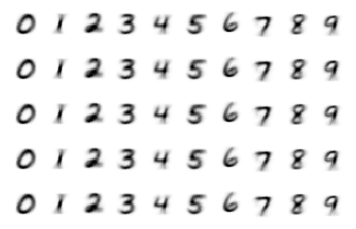

In [9]:
fig, ax = plt.subplots(5, 10)
batch_size = 2
for i in range(5):
    for j in range(10):
            c = j * torch.ones(batch_size)
            c = c.long()

            if conditional > 0:
                c.resize_(batch_size, 1)
                labels = torch.zeros(batch_size, 10)
                labels.scatter_(1, c, 1)

            if use_cuda:
                labels = labels.cuda()

            img, z = model.generate(labels)
            img = img[0,:].reshape(28, 28)
            display_sample(img, ax[i, j])

In [27]:
mnist.train

NameError: name 'mnist' is not defined